# Model Generalization: A Sharpness Aware Optimization Perspective

In [3]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd

Some helper functions

In [4]:
def get_data(folder='acc/', filename='*bz_16*[sam]*'):
    data_all = []
    for file in glob.glob(folder+filename):
        data = pd.read_csv(file)['Value'].to_list()
        data_all.append(data)
    opt_type = filename.split('*')[2]
    if opt_type == 'none': opt_type = 'SGD'
    if opt_type == 'sam': opt_type = 'SAM'
    name = filename.split('*')[1] + ' ' + opt_type
    data = np.array(data_all)
    return name, data

In [5]:
def get_first_layer_weights(path):
    state_dict = torch.load(path)
    return list(state_dict['model_state_dict'].items())[0][1].flatten().cpu().numpy()

## Experiment 1 & 2

In [6]:
name_list = [
    '*bz_16*sam*', '*bz_64*sam*', '*bz_128*sam*',
    '*bz_16*none*', '*bz_64*none*', '*bz_128*none*',
]

bz_16 SAM [0.79930001 0.80409998 0.80140001]
bz_64 SAM [0.74970001 0.74809998 0.75389999]
bz_128 SAM [0.71219999 0.70779997 0.7098    ]
bz_16 SGD [0.759      0.755      0.75550002]
bz_64 SGD [0.70590001 0.70450002 0.70520002]
bz_128 SGD [0.65149999 0.64029998 0.64170003]


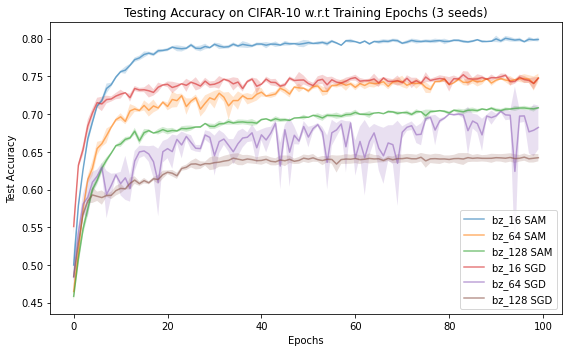

In [7]:
plt.subplots(1, figsize=(8, 5))
for i, dset in enumerate(name_list):
    name, data = get_data('acc/', dset)
    
    # Report accuracy of SAM (50) and SGD(100)
    if 'SAM' in name:
        print(name, data[:50].max(1))
    elif 'SGD' in name:
        print(name, data.max(1))
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    num_curves = data.shape[0]
    epochs = data.shape[1]
    plt.plot(np.arange(epochs), mean, label=name, alpha=0.6)
    plt.fill_between(np.arange(epochs), mean-std, mean+std, alpha=0.2)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Test Accuracy')
    plt.title('Testing Accuracy on CIFAR-10 w.r.t Training Epochs (3 seeds)')
plt.tight_layout()
plt.savefig('test_acc.pdf')

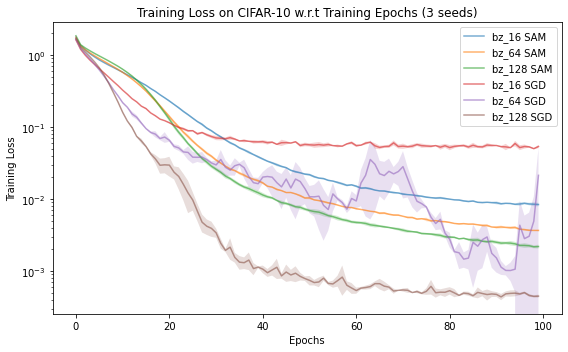

In [8]:
plt.subplots(1, figsize=(8, 5))
plt.yscale('log')
for i, dset in enumerate(name_list):
    name, data = get_data('loss/', dset)
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    num_curves = data.shape[0]
    epochs = data.shape[1]
    plt.plot(np.arange(epochs), mean, label=name, alpha=0.6)
    plt.fill_between(np.arange(epochs), mean-std, mean+std, alpha=0.2)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.title('Training Loss on CIFAR-10 w.r.t Training Epochs (3 seeds)')
plt.tight_layout()
plt.savefig('test_loss.pdf')

## Experiment 3

In [140]:
# Loading the data

asam_layer_1 = get_first_layer_weights('/home/pc/Documents/OptML-Project/runs/bz_128_seed_1_epochs[200]_model_resnet18_baseoptim[sgd]_secoptim[asam]_norm_none_batchnorm_False_lr_0.01_momentum_0.9_rho_0.5_cos_True.pt')

b_norm_asam_layer_1 = get_first_layer_weights('/home/pc/Documents/OptML-Project/runs/bz_128_seed_1_epochs[200]_model_resnet18_baseoptim[sgd]_secoptim[asam]_norm_none_batchnorm_True_lr_0.01_momentum_0.9_rho_0.5_cos_True.pt')

sam_layer_1 = get_first_layer_weights('/home/pc/Documents/OptML-Project/runs/bz_128_seed_1_epochs[200]_model_resnet18_baseoptim[sgd]_secoptim[sam]_norm_none_batchnorm_False_lr_0.01_momentum_0.9_rho_0.05_cos_True.pt')

b_norm_sam_layer_1 = get_first_layer_weights('/home/pc/Documents/OptML-Project/runs/bz_128_seed_1_epochs[200]_model_resnet18_baseoptim[sgd]_secoptim[sam]_norm_none_batchnorm_True_lr_0.01_momentum_0.9_rho_0.05_cos_True.pt')

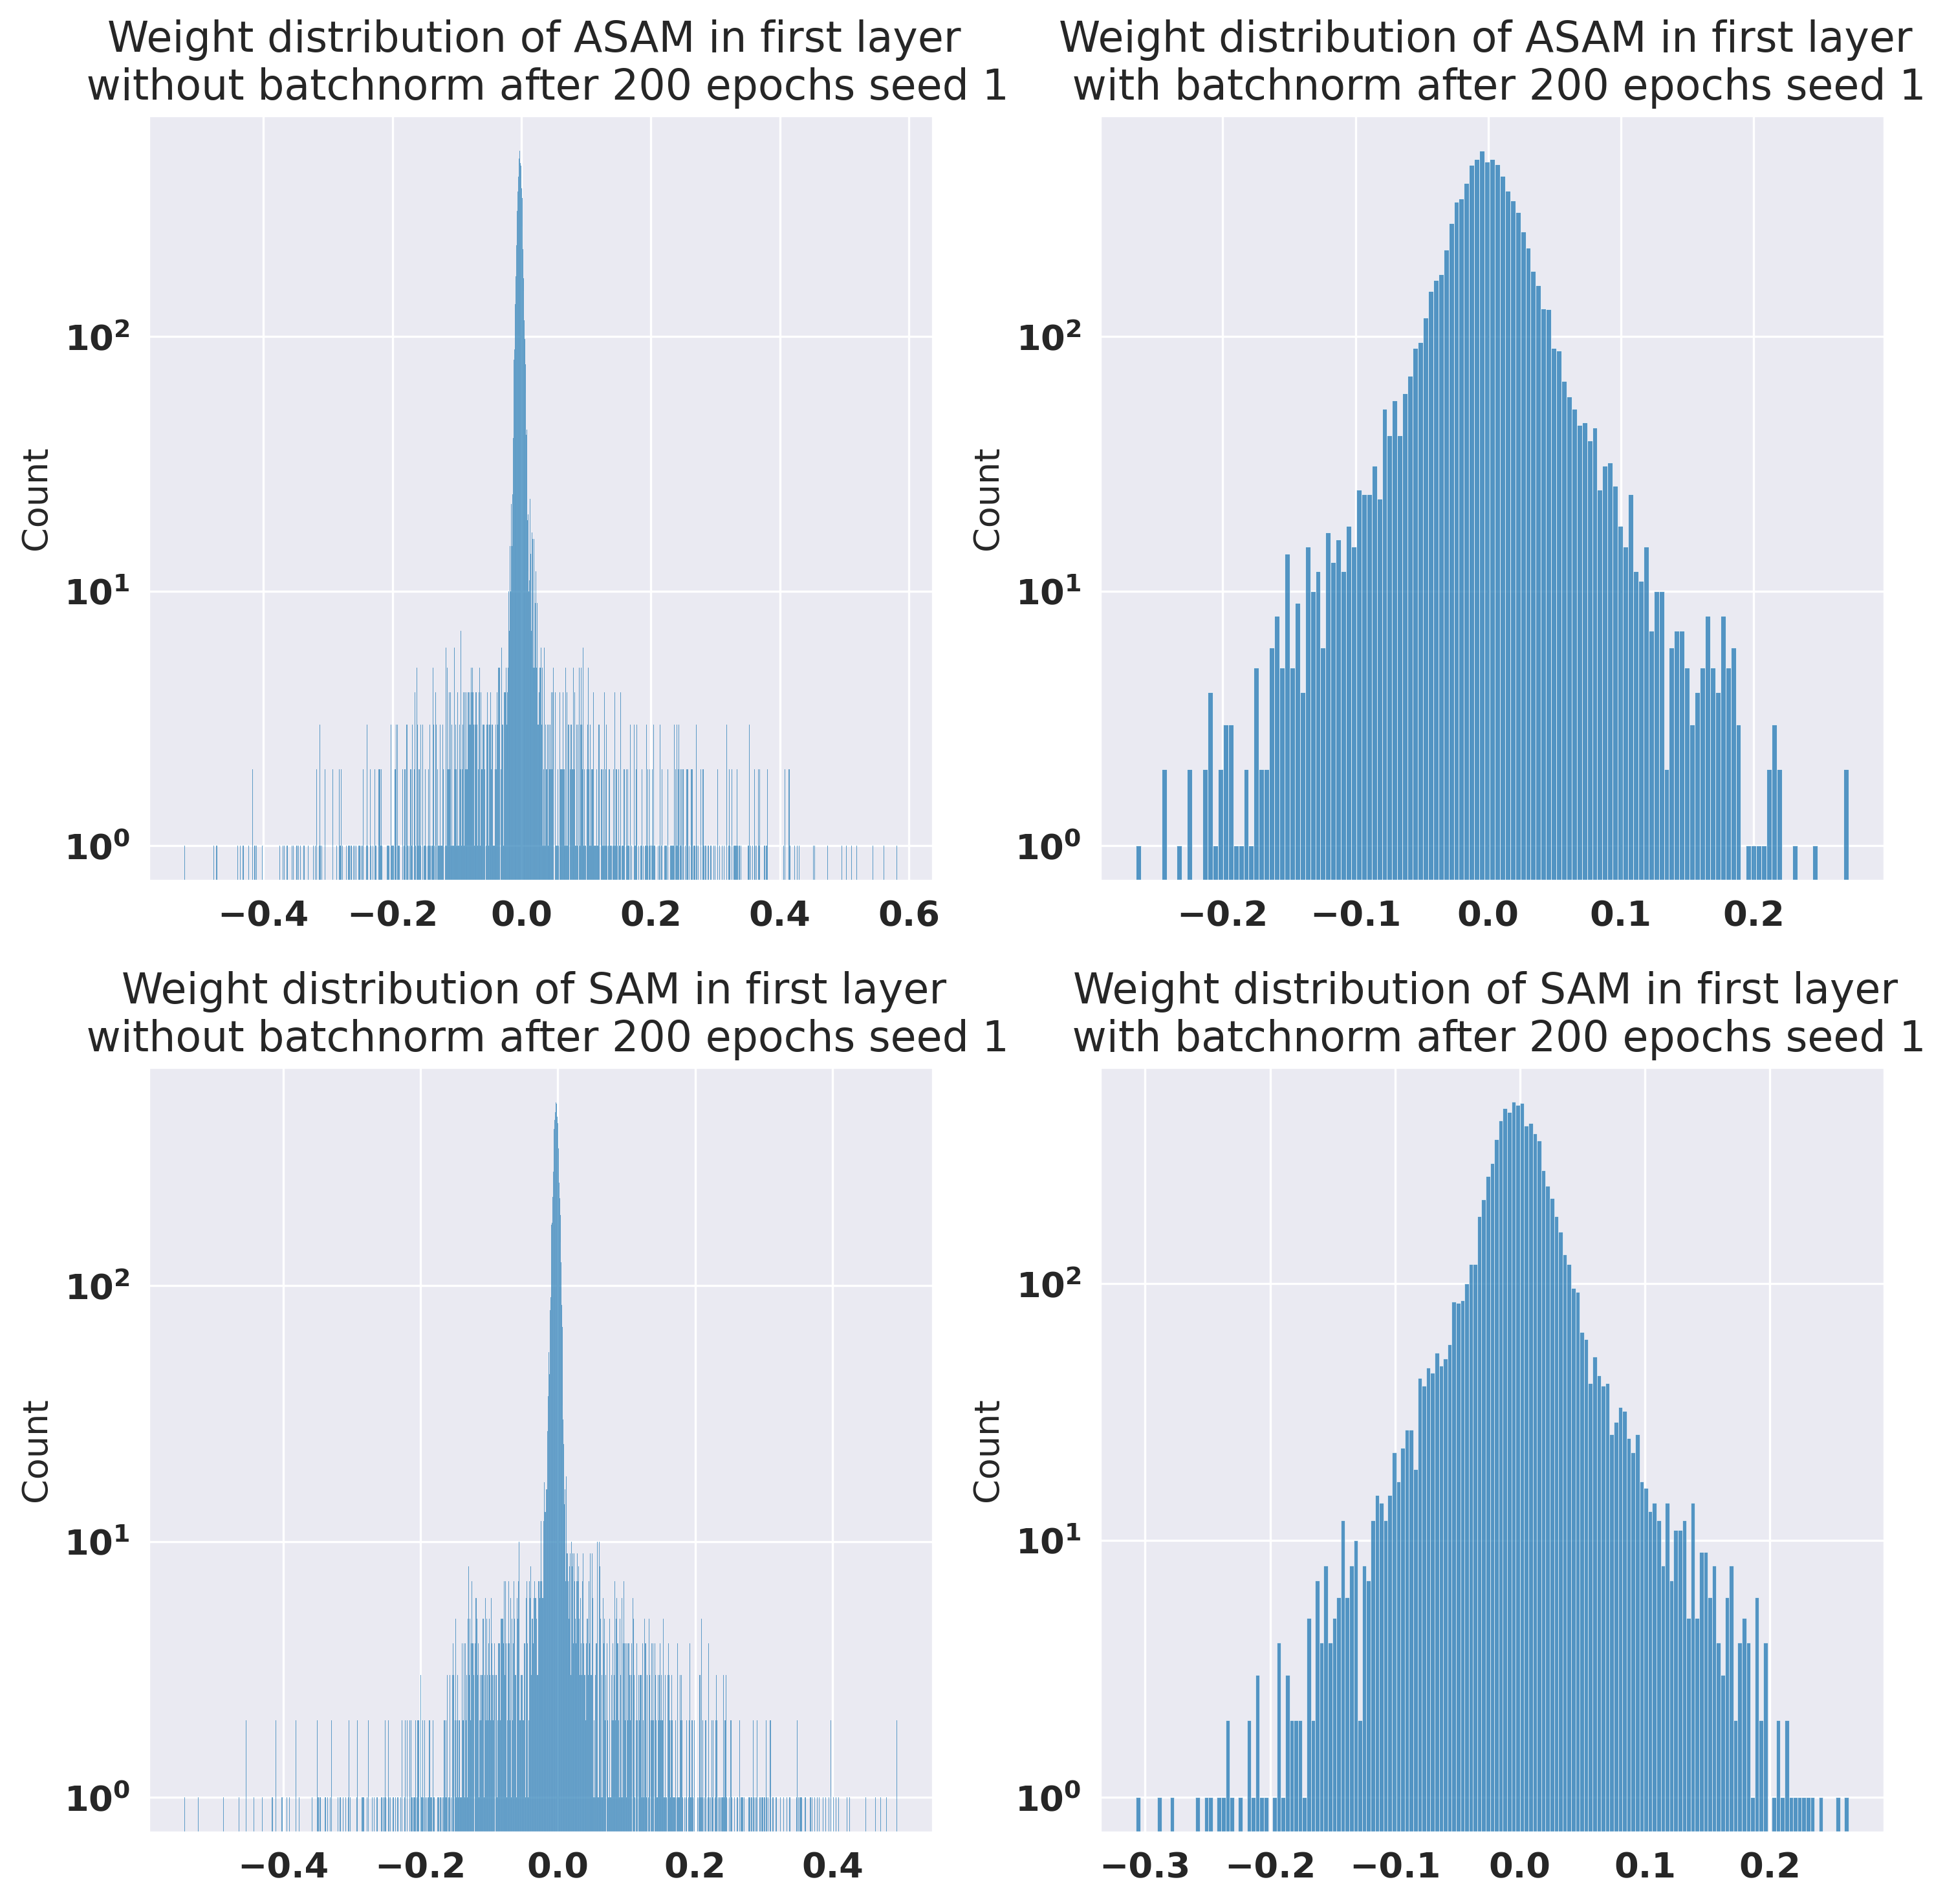

In [141]:
font = {'size'   : 13}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(2,2, figsize=(10,10), dpi = 300)
axs = axs.ravel()

ax = sns.histplot(asam_layer_1, ax=axs[0])
ax.set(title='Weight distribution of ASAM in first layer \n without batchnorm after 200 epochs seed 1', yscale='log')

ax = sns.histplot(b_norm_asam_layer_1, ax=axs[1])
ax.set(title='Weight distribution of ASAM in first layer \n with batchnorm after 200 epochs seed 1', yscale='log')


ax = sns.histplot(sam_layer_1, ax=axs[2])
ax.set(title='Weight distribution of SAM in first layer \n without batchnorm after 200 epochs seed 1', yscale='log')

ax = sns.histplot(b_norm_sam_layer_1, ax=axs[3])
ax.set(title='Weight distribution of SAM in first layer \n with batchnorm after 200 epochs seed 1', yscale='log')

plt.tight_layout()
plt.savefig("Weight_distribution_first_layer.png")
plt.show()

# OOD thing

In [200]:
from torchvision.transforms import transforms
import torchvision
from torchvision import models

def get_ood_eval(path, mult = True):
    if mult:
        ood_scales = [1 + n * 0.25 for n in range(15)]
    else:
        ood_scales = [ n * 0.1 for n in range(15)]
    accuracies = []
    for ood_scale in ood_scales:
        state_dict = torch.load(path)
        model = models.resnet18(pretrained=False)
        model.load_state_dict(state_dict['model_state_dict'])
        model.to('cuda')
        if mult:
            ood_transform = transforms.Lambda(lambda x: x * ood_scale)
        else:
            ood_transform = transforms.Lambda(lambda x: x + ood_scale)
        testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose(
                    [transforms.ToTensor(),
                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                     ood_transform]))

        testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                                              shuffle=False, num_workers=2)
        total_correct = 0
        total = 0
        model.eval()
        # again no gradients needed
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to('cuda'), labels.to('cuda')
                outputs = model(images)
                _, predictions = torch.max(outputs, 1)
                # collect the correct predictions for each class
                for label, prediction in zip(labels, predictions):
                    total += 1
                    if label == prediction:
                        total_correct += 1

        accuracies.append(total_correct / total)
        print(f"Accuracy {total_correct / total}")
    return accuracies, ood_scales


In [201]:
base_path = '/home/pc/Downloads'
sgd_model_path = 'bz_16_seed_20_epochs[100]_model_resnet18_baseoptim[sgd]_secoptim[none]_norm_normalize_batchnorm_True_lr_0.01_momentum_0_rho_0.05_cos_False.pt'
sam_model_path = 'bz_16_seed_20_epochs[100]_model_resnet18_baseoptim[sgd]_secoptim[sam]_norm_normalize_batchnorm_True_lr_0.01_momentum_0_rho_0.05_cos_False.pt'
sgd_accuracies, ood_scales = get_ood_eval(base_path + '/' + sgd_model_path)

Files already downloaded and verified
Accuracy 0.748
Files already downloaded and verified
Accuracy 0.7396
Files already downloaded and verified
Accuracy 0.7191
Files already downloaded and verified
Accuracy 0.6962
Files already downloaded and verified
Accuracy 0.6686
Files already downloaded and verified
Accuracy 0.6443
Files already downloaded and verified
Accuracy 0.6184
Files already downloaded and verified
Accuracy 0.5934
Files already downloaded and verified
Accuracy 0.576
Files already downloaded and verified
Accuracy 0.5591
Files already downloaded and verified
Accuracy 0.5411
Files already downloaded and verified
Accuracy 0.5228
Files already downloaded and verified
Accuracy 0.5068
Files already downloaded and verified
Accuracy 0.4914
Files already downloaded and verified
Accuracy 0.479


In [202]:
sam_accuracies, _ = get_ood_eval(base_path + '/' + sam_model_path)

Files already downloaded and verified
Accuracy 0.7963
Files already downloaded and verified
Accuracy 0.7873
Files already downloaded and verified
Accuracy 0.7704
Files already downloaded and verified
Accuracy 0.7457
Files already downloaded and verified
Accuracy 0.7213
Files already downloaded and verified
Accuracy 0.699
Files already downloaded and verified
Accuracy 0.6791
Files already downloaded and verified
Accuracy 0.6578
Files already downloaded and verified
Accuracy 0.6383
Files already downloaded and verified
Accuracy 0.6223
Files already downloaded and verified
Accuracy 0.6041
Files already downloaded and verified
Accuracy 0.5891
Files already downloaded and verified
Accuracy 0.5744
Files already downloaded and verified
Accuracy 0.5598
Files already downloaded and verified
Accuracy 0.5449


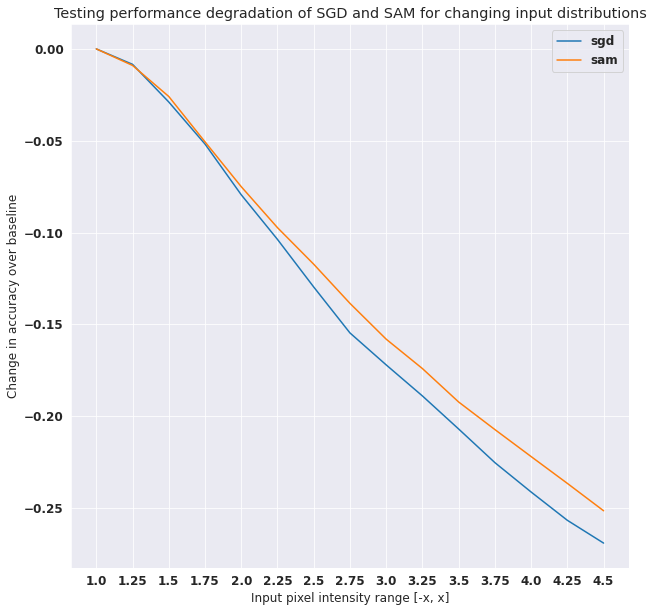

In [203]:
font = {'size'   : 12}
matplotlib.rc('font', **font)
figure = plt.figure(figsize=(10,10))
plt.plot(ood_scales, [x - sgd_accuracies[0] for x in sgd_accuracies], label = 'sgd')
plt.plot(ood_scales, [x - sam_accuracies[0] for x in sam_accuracies], label = 'sam')
plt.xticks(ood_scales, ood_scales)
plt.xlabel('Input pixel intensity range [-x, x]')
plt.ylabel('Change in accuracy over baseline')
plt.title('Testing performance degradation of SGD and SAM for changing input distributions')
plt.legend()

In [204]:
base_path = '/home/pc/Downloads'
sgd_model_path = 'bz_16_seed_20_epochs[100]_model_resnet18_baseoptim[sgd]_secoptim[none]_norm_normalize_batchnorm_True_lr_0.01_momentum_0_rho_0.05_cos_False.pt'
sam_model_path = 'bz_16_seed_20_epochs[100]_model_resnet18_baseoptim[sgd]_secoptim[sam]_norm_normalize_batchnorm_True_lr_0.01_momentum_0_rho_0.05_cos_False.pt'
sgd_accuracies, ood_scales = get_ood_eval(base_path + '/' + sgd_model_path, mult=False)
sam_accuracies, _ = get_ood_eval(base_path + '/' + sam_model_path, mult=False)

Files already downloaded and verified
Accuracy 0.748
Files already downloaded and verified
Accuracy 0.7433
Files already downloaded and verified
Accuracy 0.7333
Files already downloaded and verified
Accuracy 0.7161
Files already downloaded and verified
Accuracy 0.699
Files already downloaded and verified
Accuracy 0.6702
Files already downloaded and verified
Accuracy 0.6357
Files already downloaded and verified
Accuracy 0.6009
Files already downloaded and verified
Accuracy 0.559
Files already downloaded and verified
Accuracy 0.5152
Files already downloaded and verified
Accuracy 0.4764
Files already downloaded and verified
Accuracy 0.4369
Files already downloaded and verified
Accuracy 0.4056
Files already downloaded and verified
Accuracy 0.368
Files already downloaded and verified
Accuracy 0.3386
Files already downloaded and verified
Accuracy 0.7963
Files already downloaded and verified
Accuracy 0.7958
Files already downloaded and verified
Accuracy 0.7893
Files already downloaded and ver

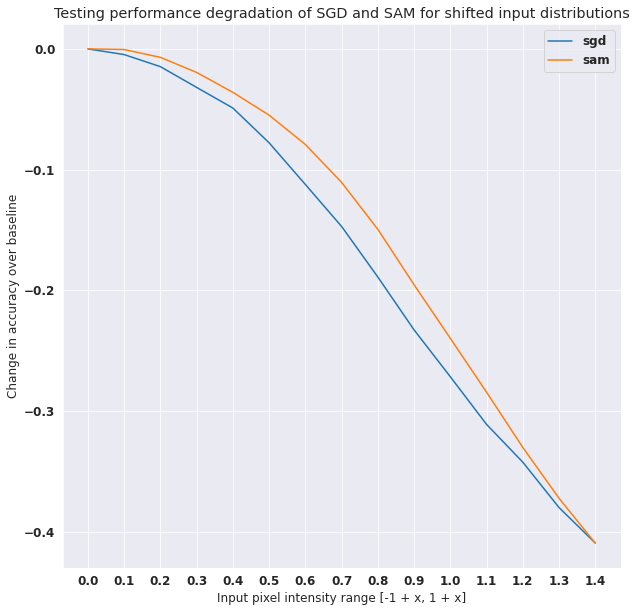

In [205]:
figure = plt.figure(figsize=(10,10))
plt.plot(ood_scales, [x - sgd_accuracies[0] for x in sgd_accuracies], label = 'sgd')
plt.plot(ood_scales, [x - sam_accuracies[0] for x in sam_accuracies], label = 'sam')
plt.xticks(ood_scales, [round(x, 4) for x in ood_scales])
plt.xlabel('Input pixel intensity range [-1 + x, 1 + x]')
plt.ylabel('Change in accuracy over baseline')
plt.title('Testing performance degradation of SGD and SAM for shifted input distributions')
plt.legend()